#### Project Overview

This is the first Captone project for SpringBoard using the UCI dataset: Diabetes 130-US hospitals for years 1999-2008 Data Set. Detailed description of the dataset can be found here - https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008.

### Step One - Data Wrangling
First step is to read in the CSV file and explore the data to check for:
1) non-numerical values
2) missing cells

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [329]:
df=pd.read_csv('/Users/YingShen/Desktop/Data_Science/SpringBorad/Git/dataset_diabetes/diabetic_data.csv')

In [142]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

#### Feature selection
Before using Pandas to do data wrangling, EXCEL itself can be useful to filter out some features that have too many missingness, including:

weight: 98569;
payer_code: 40256;
medical_specialty: 49949

In addition, 24 features of medications are not used neither since there is one variable that can represent all of them.

In [330]:
# Select the features we need to process
df=df[['patient_nbr', 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'change', 'diabetesMed', 'readmitted']] 

# Drop duplicate patients
df.drop_duplicates(subset=["patient_nbr","gender"],inplace=True) 

# Transform strings to dummy values
df["gender_d"]=df["gender"].apply(lambda x: 1 if x=="Male" else 0) 
age_dict={"[0-10)":1,"[10-20)":2,"[20-30)":3,"[30-40)":4,"[40-50)":5,"[50-60)":6,
          "[60-70)":7,"[70-80)":8,"[80-90)":9,"[90-100)":10}
df["age_mapped"]=df["age"].map(age_dict)
df['race']=df['race'].apply(lambda x: "Other" if x=="?" else x)

In [331]:
# Drop encounters that ended in deaths or hospice
df=df[df['discharge_disposition_id'].isin([11,13,14,19,20,21])==False]
df['dischar_home']=df['discharge_disposition_id'].apply(lambda x: 1 if x==1 or x==6 or x==8 else 0)

In [332]:
df['readmitted'].value_counts()

NO     41475
>30    22224
<30     6277
Name: readmitted, dtype: int64

In [333]:
# Categorize admission source codes into 1: emergency; 2: referral; 3: other
df['admission_source_id'].value_counts()
def ad_cource_group(value):
    if value==7 or value==25:
        return 1
    if 1<=value<=6 or value==10 or value==18 or value==22 or value==26:
        return 2
    else: return 3
df['admis_source_group']=df['admission_source_id'].apply(ad_cource_group)

In [334]:
df['max_glu_dummy']=df['max_glu_serum'].apply(lambda x: 0 if x=="None" else 1)
df['A1Cresult_dummy']=df['A1Cresult'].apply(lambda x: 0 if x=="None" else 1)
df['change_d']=df['change'].apply(lambda x: 1 if x=="Ch" else 0)
df['diabetesMed_d']=df['diabetesMed'].apply(lambda x: 1 if x=="Yes" else 0)
df['readmitted_d']=df['readmitted'].apply(lambda x: 1 if x=="<30" else 0)
df[["Caucasian","African_American","Other","Hispanic","Asian"]]=pd.get_dummies(df['race'])

In [267]:
cleaned_df=df[["race","Caucasian","African_American","Other","Hispanic","Asian", 'gender','gender_d', 'age_mapped', 
               'dischar_home','admis_source_group',
               'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
               'num_medications','number_outpatient', 'number_emergency', 
               'number_inpatient', 'diag_1','diag_2', 'diag_3', 'number_diagnoses', 
               'max_glu_dummy', 'A1Cresult_dummy','change_d', 'diabetesMed_d', 'readmitted_d']]

### Step Two - Exploratory Data Analysis
Several Preliminary Questions to Ask :

1. Since this is a claims study regarding a clinical outcome (readmission), patient characteristics should be strong indicators for the outcome; is it the case for the patient characteristics included in this study?
2. As commonly observed in clinical studies, exposure variables can have interactive impact on each other; How can I have a preliminary analysis of that?
3. What plots can I make to visually help me identify potential trend and relationship among all given variables and the target outcome? What plots are appropriate given the data type?

Considering that the outcome variable is 1 or 0, and most predictors are categorical, barcharts of the outcome counts would be useful to visualize difference of occurrence among different groups.
To answer the above questions, following plots using the sns.countplot were made:

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


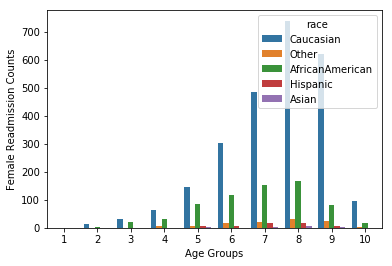

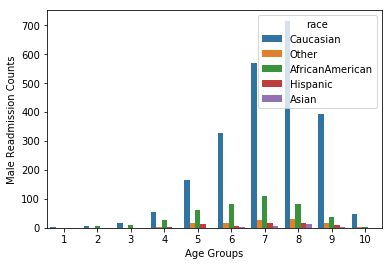

In [305]:
import seaborn as sns

# Get only the readmitted observations for later counting charts
vis_df=df[df['readmitted_d']==1]

# Generate female and male categories
female_vis=vis_df[vis_df["gender"]=='Female']
male_vis=vis_df[vis_df["gender"]=='Male']

# Generate count plots of multiple categories in one figure
g=sns.countplot(x='age_mapped',data=female_vis,hue='race',hue_order=['Caucasian','Other','AfricanAmerican','Hispanic','Asian'])
plt.ylabel("Female Readmission Counts")
plt.xlabel("Age Groups")
plt.show()

g=sns.countplot(x='age_mapped',data=male_vis,hue='race',hue_order=['Caucasian','Other','AfricanAmerican','Hispanic','Asian'])
plt.ylabel("Male Readmission Counts")
plt.xlabel("Age Groups")

plt.show()

As suggested by the above figure, senior and white people seems to have higher readmission rates, but gender seems to have no influence of the overall trend. 

For the following plots that explore impact of other variables, I will always display the impact of age.

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


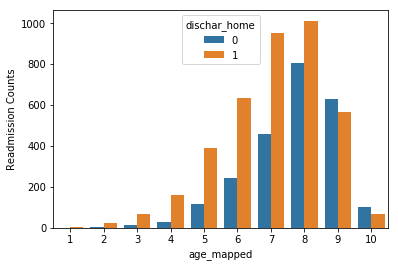

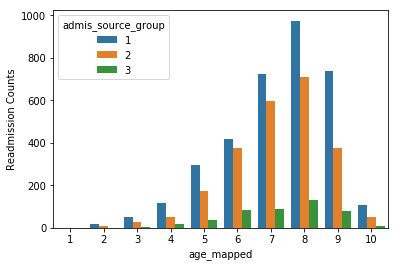

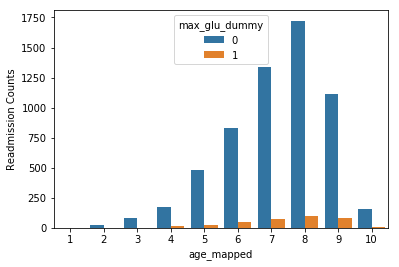

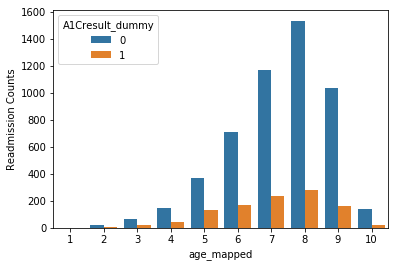

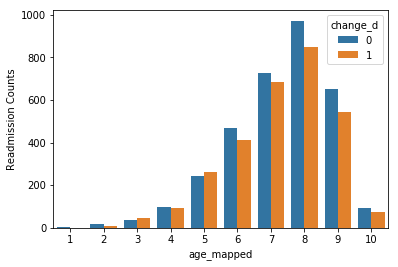

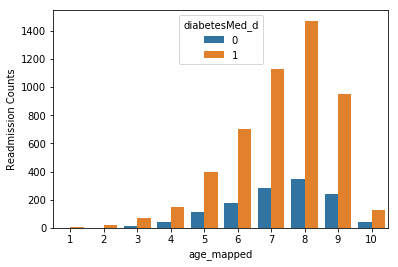

In [304]:
g=sns.countplot(x='age_mapped',data=vis_df,hue='dischar_home')
plt.ylabel("Readmission Counts")

plt.show()

g=sns.countplot(x='age_mapped',data=vis_df,hue='admis_source_group')
plt.ylabel("Readmission Counts")

plt.show()

g=sns.countplot(x='age_mapped',data=vis_df,hue='max_glu_dummy')
plt.ylabel("Readmission Counts")

plt.show()

g=sns.countplot(x='age_mapped',data=vis_df,hue='A1Cresult_dummy')
plt.ylabel("Readmission Counts")

plt.show()

g=sns.countplot(x='age_mapped',data=vis_df,hue='change_d')
plt.ylabel("Readmission Counts")

plt.show()
g=sns.countplot(x='age_mapped',data=vis_df,hue='diabetesMed_d')
plt.ylabel("Readmission Counts")

plt.show()

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


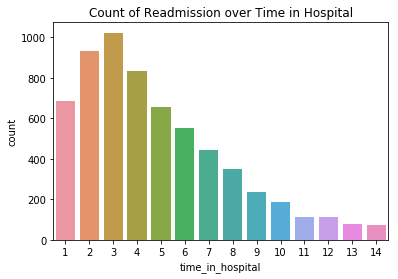

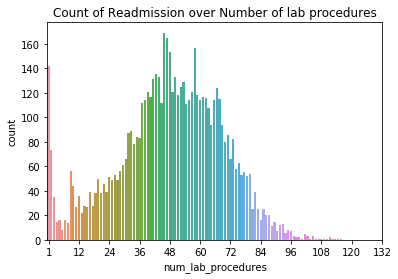

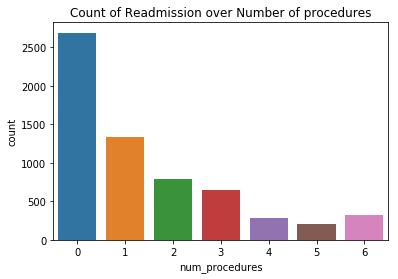

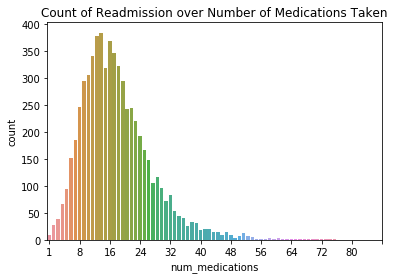

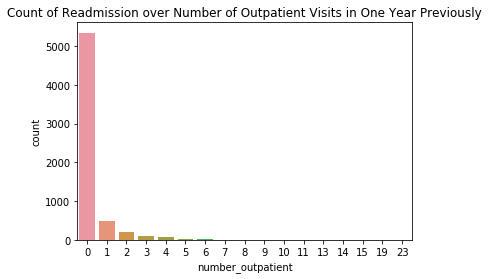

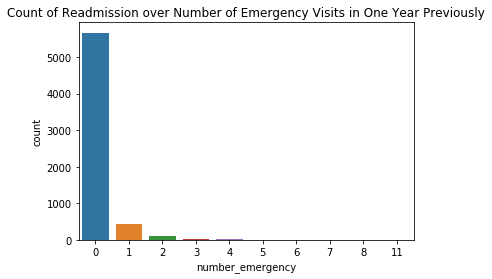

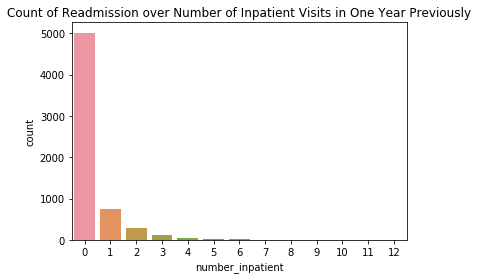

In [302]:
g=sns.countplot(x="time_in_hospital", data=vis_df)
plt.title('Count of Readmission over Time in Hospital')
plt.show()

g=sns.countplot(x="num_lab_procedures", data=vis_df)
plt.title('Count of Readmission over Number of lab procedures')
plt.xticks(np.arange(132,step=11),(1,12,24,36,48,60,72,84,96,108,120,132))
plt.show()

g=sns.countplot(x="num_procedures", data=vis_df)
plt.title('Count of Readmission over Number of procedures')
plt.show()

g=sns.countplot(x="num_medications", data=vis_df)
plt.title('Count of Readmission over Number of Medications Taken')
plt.xticks(np.arange(80,step=7),(1,8,16,24,32,40,48,56,64,72,80))
plt.show()

g=sns.countplot(x="number_outpatient", data=vis_df)
plt.title('Count of Readmission over Number of Outpatient Visits in One Year Previously')
plt.show()

g=sns.countplot(x="number_emergency", data=vis_df)
plt.title('Count of Readmission over Number of Emergency Visits in One Year Previously')
plt.show()


g=sns.countplot(x="number_inpatient", data=vis_df)
plt.title('Count of Readmission over Number of Inpatient Visits in One Year Previously')
plt.show()

#### Further questions to ask:

Based on the plots, the distribution of the readmission counts among each feature seems to have a poisson distribution. This is likely to happen since the outcome can also be treated as rare events.

For future inferential statistical analysis, the next question is about what model should be used to fit the data. Whether a logistic regression model or a poisson model is appropriate can be explored later.

Another action step is to further categorize three variables (number of previous inpatient,outpatient,emergency visits) into dummies based on the plots of readmission counts.